In [1]:
# ['TerminateOnNaNCallback', 'EarlyStoppingCallback', 'SaveModelCallback', 'TrackerCallback',
#         'ReduceLROnPlateauCallback', 'TrackEpochCallback' ]

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#export
from lib.nb_06 import *

### Get model and Data

In [4]:
x_train, y_train, x_valid, y_valid = get_mnist();

/Users/vks/anaconda3/envs/my-fastai/lib/python3.6/site-packages/fastai/datasets.py:164: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  with open(fpath, 'r') as yaml_file: return yaml.load(yaml_file)


In [5]:
def normalize_to(x_train, x_valid):
    m, s = x_train.mean(), x_train.std()
    return normalize(x_train, m, s), normalize(x_valid, m, s)

In [6]:
x_train, x_valid = normalize_to(x_train, x_valid)

In [7]:
bs=64

In [8]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs=bs, num_workers=6)

In [9]:
data = Databunch(train_dl, valid_dl, c_in=28*28, c_out=10)

In [10]:
def get_model(data):
    model = nn.Sequential(nn.Linear(data.c_in,200), nn.ReLU(), nn.Linear(200, data.c_out))
    return model

In [11]:
model = get_model(data)

In [12]:
cbfs = [partial(AvgStatsCallback,accuracy), ProgressCallback]

In [13]:
learn = Learner(model, data, F.cross_entropy, opt_func=adam_opt(), cb_funcs=cbfs)

In [14]:
learn.fit(5)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.296730,0.915320,0.235956,0.942000,00:02
1,0.217137,0.945000,0.231099,0.942300,00:03
2,0.190475,0.951760,0.225516,0.948800,00:03
3,0.187237,0.953480,0.223593,0.952200,00:03
4,0.172973,0.957800,0.223613,0.949100,00:04


In [15]:
cbfs = [partial(AvgStatsCallback,accuracy), Recorder, ProgressCallback]

In [16]:
learn = Learner(model, data, F.cross_entropy, opt_func=adam_opt(), cb_funcs=cbfs)

In [17]:
learn.fit(1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.168571,0.960720,0.229004,0.951000,00:03


In [18]:
learn.avg_stats.valid_stats.avg_stats

[0.229004052734375, tensor(0.9510)]

In [19]:
learn.avg_stats.train_stats.avg_stats

[0.16857056640625, tensor(0.9607)]

In [20]:
learn.avg_stats.train_stats.metrics[0].__name__

'accuracy'

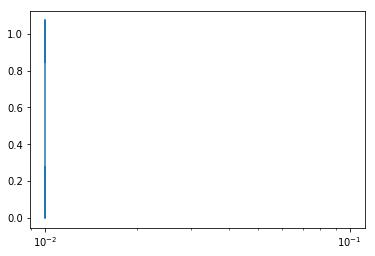

In [21]:
learn.recorder.plot()

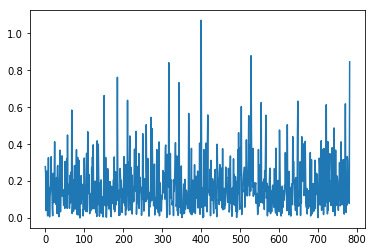

In [22]:
learn.recorder.plot_loss()

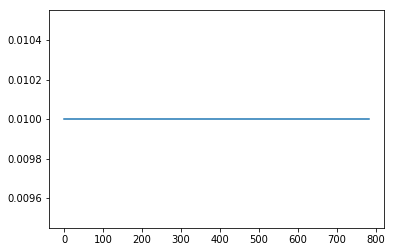

In [23]:
learn.recorder.plot_lr()

In [24]:
learn.recorder.losses

[tensor(0.2784),
 tensor(0.2385),
 tensor(0.0404),
 tensor(0.0893),
 tensor(0.2542),
 tensor(0.0847),
 tensor(0.0119),
 tensor(0.1268),
 tensor(0.3269),
 tensor(0.0999),
 tensor(0.1639),
 tensor(0.0060),
 tensor(0.1131),
 tensor(0.1405),
 tensor(0.1941),
 tensor(0.3319),
 tensor(0.1761),
 tensor(0.1652),
 tensor(0.0489),
 tensor(0.0122),
 tensor(0.2419),
 tensor(0.2383),
 tensor(0.0829),
 tensor(0.2186),
 tensor(0.4135),
 tensor(0.1527),
 tensor(0.1257),
 tensor(0.1048),
 tensor(0.0729),
 tensor(0.2193),
 tensor(0.0251),
 tensor(0.2757),
 tensor(0.2848),
 tensor(0.1917),
 tensor(0.0207),
 tensor(0.0074),
 tensor(0.1822),
 tensor(0.2186),
 tensor(0.3677),
 tensor(0.0339),
 tensor(0.1931),
 tensor(0.1499),
 tensor(0.1497),
 tensor(0.3368),
 tensor(0.1176),
 tensor(0.1543),
 tensor(0.1476),
 tensor(0.0680),
 tensor(0.0747),
 tensor(0.1115),
 tensor(0.0525),
 tensor(0.3068),
 tensor(0.0816),
 tensor(0.1902),
 tensor(0.1574),
 tensor(0.3214),
 tensor(0.0526),
 tensor(0.4498),
 tensor(0.1344

### Admin Callbacks: TerminateOnNaNCallback

In [25]:
#export
class TerminateOnNaNCallback(Callback):
    "A `Callback` that terminates training if loss is NaN." 
    def __init__(self):
        self.last_loss=np.inf
    
    def after_loss(self):
        
        if(torch.isnan(self.loss)):
            print("Loss of current batch NaN, Stopping")
            print(f"Loss for last Batch is {self.last_loss}")
            raise CancelTrainException()
            
        self.last_loss = self.loss

In [26]:
def nan_check_loss_func(x,y):
    return F.cross_entropy(x,y)*torch.tensor(np.nan)

In [27]:
cbfs = [partial(AvgStatsCallback,accuracy), Recorder, TerminateOnNaNCallback, ProgressCallback]
learn = Learner(model, data, nan_check_loss_func, opt_func=adam_opt(), cb_funcs=cbfs)
learn.fit(3)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


Loss of current batch NaN, Stopping
Loss for last Batch is inf


### Admin Callbacks: TrackerCallback

https://github.com/fastai/fastai/blob/master/fastai/callbacks/tracker.py

In [28]:
#export
class TrackerCallback(Callback):
    "A `Callback` that keeps track of the best value in `monitor`."
    
    def __init__(self, monitor:str='valid_loss', mode="auto"):
        super().__init__()
        self.monitor,self.mode = monitor,mode
        if self.mode not in ['auto', 'min', 'max']:
            warnings.warn(f'{self.__class__} mode {self.mode} is invalid, falling back to "auto" mode.')
            self.mode = 'auto'
        mode_dict = {'min': np.less, 'max':np.greater}
        mode_dict['auto'] = np.less if 'loss' in self.monitor else np.greater
        self.operator = mode_dict[self.mode]
        
    def begin_fit(self):
        "Initializes the best value."
        self.best = float('inf') if self.operator == np.less else -float('inf')
        
    def get_monitor_value(self):
        "Pick the monitored value."
        values = {"train_loss": self.run.avg_stats.train_stats.avg_stats[0], 
                  "valid_loss": self.run.avg_stats.valid_stats.avg_stats[0]}
        
        if values.get(self.monitor) is None:
            warnings.warn(f'{self.__class__} conditioned on metric `{self.monitor}` which is not available.')
        
        return values.get(self.monitor)

In [29]:
#export
class SaveModelCallback(TrackerCallback):
    "A `TrackerCallback` that saves the model when monitored quantity is best."
    
    _order = 10000 ##probably this needs to be the last cb that is invoked
    
    def __init__(self, savename = "test_cb", monitor:str='valid_loss', mode:str='auto', 
                 every:str='improvement', name:str='bestmodel'):
        
        super().__init__(monitor=monitor, mode=mode)
        
        self.every, self.best_epoch = every, 0
        if self.every not in ['improvement', 'epoch']:
            warnings.warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')
            self.every = 'improvement'
        
        self.save_path = Path(f"./models/{savename}")
        os.makedirs(self.save_path, exist_ok=True)
                 
    
    def after_epoch(self):
        "Compare the value monitored to its best score and maybe save the model."
        if self.every=="epoch": 
            torch.save(self.run.model.state_dict(),
                       f'{self.save_path}/epoch:{self.epoch}_{self.get_monitor_value()}.pth')
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                print(f'Better model found at epoch {self.epoch} with {self.monitor} value: {current}.')
                self.best = current
                self.best_epoch = self.epoch
                torch.save(self.run.model.state_dict(),
                           f'{self.save_path}/epoch:{self.epoch}_{self.best}.pth')
                
                
    def after_fit(self):
        "Load the best model."
        if self.every == "improvement":
            self.run.model.load_state_dict(torch.load(f'{self.save_path}/epoch:{self.best_epoch}_{self.best}.pth'))
            print(f"Loaded the best model found at Epoch:{self.best_epoch}")
            

In [30]:
cbfs = [partial(AvgStatsCallback,accuracy), 
        Recorder, 
        partial(SaveModelCallback, savename="09", every="improvement"), 
        ProgressCallback]

model = get_model(data)

learn = Learner(model, data, F.cross_entropy, opt_func=adam_opt(), cb_funcs=cbfs)
learn.fit(5)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.299983,0.913020,0.238545,0.941900,00:03
1,0.223667,0.941480,0.274740,0.939400,00:03
2,0.197060,0.950640,0.200818,0.954800,00:04
3,0.181760,0.954720,0.203621,0.954100,00:04
4,0.176925,0.957020,0.207023,0.951900,00:04


Better model found at epoch 0 with valid_loss value: 0.2385454345703125.
Better model found at epoch 2 with valid_loss value: 0.20081766357421876.
Loaded the best model found at Epoch:2


In [31]:
!python notebook2script.py 07_admin_callbacks.ipynb

Converted 07_admin_callbacks.ipynb to lib/nb_07.py
